In [2]:
using LinearAlgebra
using TensorOperations
using ITensors, ITensorMPS
using Plots

In [3]:
N = 10
s = siteinds(3,N)
chi = 20
mps = random_mps(s;linkdims=chi)
println("Right canonical MPS bond structure $mps")

Right canonical MPS bond structure MPS
[1] ((dim=3|id=713|"Site,n=1"), (dim=20|id=838|"Link,l=1"))
[2] ((dim=20|id=838|"Link,l=1"), (dim=3|id=995|"Site,n=2"), (dim=20|id=990|"Link,l=2"))
[3] ((dim=20|id=990|"Link,l=2"), (dim=3|id=929|"Site,n=3"), (dim=20|id=280|"Link,l=3"))
[4] ((dim=20|id=280|"Link,l=3"), (dim=3|id=125|"Site,n=4"), (dim=20|id=58|"Link,l=4"))
[5] ((dim=20|id=58|"Link,l=4"), (dim=3|id=570|"Site,n=5"), (dim=20|id=747|"Link,l=5"))
[6] ((dim=20|id=747|"Link,l=5"), (dim=3|id=748|"Site,n=6"), (dim=20|id=143|"Link,l=6"))
[7] ((dim=20|id=143|"Link,l=6"), (dim=3|id=543|"Site,n=7"), (dim=20|id=957|"Link,l=7"))
[8] ((dim=20|id=957|"Link,l=7"), (dim=3|id=949|"Site,n=8"), (dim=9|id=452|"Link,l=8"))
[9] ((dim=9|id=452|"Link,l=8"), (dim=3|id=902|"Site,n=9"), (dim=3|id=786|"Link,l=9"))
[10] ((dim=3|id=786|"Link,l=9"), (dim=3|id=571|"Site,n=10"))



# MPOs of Hamiltonians

$\quad$ In this section, we show how to build the MPO of a model Hamiltonian, following the strategy explained in the manuscript. For concreteness, we focus on Hamiltonians of 1D quantum spin chains with open boundary conditions. A general representation of such an Hamiltonian MPO is depicted below, where $N$ is the number of sites in the chain and $d$ is the corresponding local dimension ($d=2s+1$ for a spin-$s$ system).

<img src="./img/MPO_Hamiltonian.png" width="50%" style="display: block; margin-left: auto; margin-right: auto;"/>
<br>

For clarity purposes, we consider four different examples, which should illustrate how to do it for a general model.

## i) XY model

$\quad$ The Hamiltonian of an XY open-ended chain is given by
$$
\hat{\mathcal{H}}_\text{XY} = -\sum_{l=0}^{N-2} \left( \hat{\sigma}^x_l \hat{\sigma}^x_{l+1} + \hat{\sigma}^y_l \hat{\sigma}^y_{l+1} \right),
$$
where $N$ is the number of $s=1/2$ spins and $\hat{\sigma}^{x/y}_l$ are the $x$/$y$ spin-1/2 operators at site $l$.

$\quad$ Straightforward manipulation gives
$$
\hat{\mathcal{H}}_\text{XY} = -\frac{1}{2} \sum_{l=0}^{N-2} \left( \hat{\sigma}^+_l \hat{\sigma}^-_{l+1} + \hat{\sigma}^-_l \hat{\sigma}^+_{l+1} \right),
$$
where $\hat{\sigma}^\pm_l = \hat{\sigma}^x_l \pm \mathrm{i} \hat{\sigma}^y_l$ are the spin ladder operators.

In [ ]:
chi = 40
N_values = [10, 50, 100, 200, 300, 500] 
gs_energy = Float64[]  
energy_per_spin = Float64[] 
    
for N in N_values
    println("Computing for system size N = $N")
    
    # Define site indices
    s = siteinds("S=1/2", N)
    
    # Define the XY model Hamiltonian
    os = OpSum()
    for l=1:N-1
        os += -0.5, "S+", l, "S-", l+1
        os += -0.5, "S-", l, "S+", l+1
    end
    
    # Convert to MPO
    H_mpo = MPO(os, s)
    
    # Setup DMRG sweeps
    sweeps = Sweeps(5)
    setmaxdim!(sweeps, 10, 20, 100)
    setcutoff!(sweeps, 1E-10)
    
    # Use random initial MPS
    psi0 = randomMPS(s, chi)
    
    # Run DMRG to find ground state
    energy, psi = dmrg(H_mpo, psi0, sweeps)
    
    # Store the results
    push!(gs_energy, energy)
    push!(energy_per_spin, energy/N)
    
    # Print results for this system size
    println("Ground state energy from DMRG = $energy")
    println("Ground state energy per spin = $(energy/N)")
    println()
end

Computing for system size N = 10
After sweep 1 energy=-3.005172220553012  maxlinkdim=10 maxerr=8.10E-04 time=0.021
After sweep 2 energy=-3.013333027194753  maxlinkdim=20 maxerr=4.16E-09 time=0.019
After sweep 3 energy=-3.0133370909220116  maxlinkdim=20 maxerr=7.23E-11 time=0.011
After sweep 4 energy=-3.0133370909795927  maxlinkdim=20 maxerr=6.40E-11 time=0.011
After sweep 5 energy=-3.013337090979592  maxlinkdim=20 maxerr=6.33E-11 time=0.009
Ground state energy from DMRG = -3.013337090979592
Ground state energy per spin = -0.3013337090979592

Computing for system size N = 50
After sweep 1 energy=-15.724781367334014  maxlinkdim=10 maxerr=9.78E-03 time=0.204
After sweep 2 energy=-15.736244725580304  maxlinkdim=20 maxerr=1.26E-06 time=0.059
After sweep 3 energy=-15.736370993730404  maxlinkdim=63 maxerr=9.98E-11 time=0.195
After sweep 4 energy=-15.736371131200716  maxlinkdim=71 maxerr=9.98E-11 time=0.392
After sweep 5 energy=-15.736371130896815  maxlinkdim=71 maxerr=9.98E-11 time=0.379
Grou

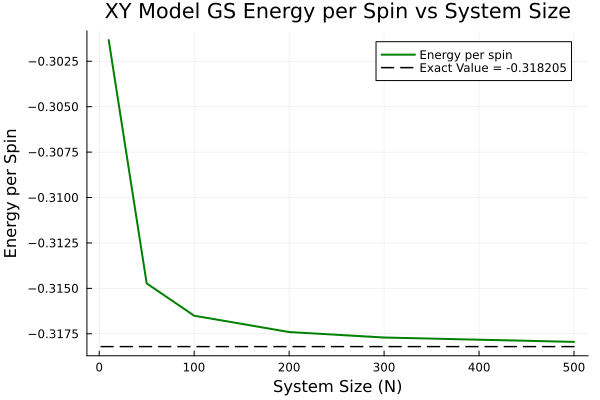

In [ ]:
plt = plot(system_sizes, energy_per_spin, 
          color=:green, 
          linewidth=2, 
          label="Energy per spin",
          xlabel="System Size (N)", 
          ylabel="Energy per Spin", 
          title="XY Model GS Energy per Spin vs System Size")
plot!(plt, [2, 500], [-0.318205, -0.318205],
     line=:dash,
     color=:black,
     linewidth=1.5,
     label="Exact Value = -0.318205")
savefig("xy_model_energy.png")
plt

## ii) Spin-1 Heisenberg model with Zeeman term

$\quad$ The Hamiltonian for an open-ended Heisenberg chain of $N$ $s=1$ spins, with a Zeeman term, is given by
$$
\hat{\mathcal{H}}_\text{Heis} = J \sum_{l=0}^{N-2} \hat{\vec{S}}_l \cdot \hat{\vec{S}}_{l+1} - h \sum_{l=0}^{N-1} \hat{S}^z_l,
$$
where $J$ and $h$ are model parameters, and $\hat{\vec{S}}_l = (\hat{S}^x_l, \hat{S}^y_l, \hat{S}^z_l)$ is the vector of spin-1 operators at site $l$.

$\quad$ Straightforward manipulation leads to
$$
\hat{\mathcal{H}}_\text{Heis} = J \sum_{l=0}^{N-2} \left( \hat{S}^z_l \hat{S}^z_{l+1} + \frac{1}{2} \hat{S}^+_l \hat{S}^-_{l+1} + \frac{1}{2} \hat{S}^-_l \hat{S}^+_{l+1} \right) - h \sum_{l=0}^{N-1} \hat{S}^z_l,
$$
where $\hat{S}^\pm_l = \hat{S}^x_l \pm \mathrm{i} \hat{S}^y_l$ are the spin ladder operators.

In [43]:
N = 100
chi = 20
N_values = [10, 50, 100, 200, 300, 500] 
gs_energy = Float64[]  
energy_per_spin = Float64[] 


for N in N_values
    println("Computing for system size N = $N")
    sites = siteinds("S=1",N)

    os = OpSum()
    for l=1:N-1
        os += "Sz",l,"Sz",l+1
        os += 0.5,"S+",l,"S-",l+1
        os += 0.5,"S-",l,"S+",l+1
        os += -1,"Sz",l
    end

    for l=1:N
        os += -1,"Sz",l
    end

    H = MPO(os,sites)

    nsweeps = 5 # number of sweeps is 5
    maxdim = [10,20,100,200] # gradually increase states kept
    cutoff = [1E-10] # desired truncation error

    psi0 = random_mps(sites;linkdims=chi)

    energy,psi = dmrg(H,psi0;nsweeps,maxdim,cutoff)

    # Store the results
    push!(gs_energy, energy)
    push!(energy_per_spin, energy/N)
    
    # Print results for this system size
    println("Ground state energy from DMRG = $energy")
    println("Ground state energy per spin = $(energy/N)")
    println()
end


Computing for system size N = 10
After sweep 1 energy=-16.353121468398005  maxlinkdim=10 maxerr=1.30E-02 time=0.026
After sweep 2 energy=-16.412152832589655  maxlinkdim=20 maxerr=3.69E-07 time=0.017
After sweep 3 energy=-16.415869184251306  maxlinkdim=47 maxerr=9.51E-11 time=0.128
After sweep 4 energy=-16.416123457345176  maxlinkdim=44 maxerr=9.14E-11 time=0.044
After sweep 5 energy=-16.416141580910597  maxlinkdim=42 maxerr=9.47E-11 time=0.038
Ground state energy from DMRG = -16.416141580910597
Ground state energy per spin = -1.6416141580910597

Computing for system size N = 50
After sweep 1 energy=-84.7170782436741  maxlinkdim=10 maxerr=1.62E-02 time=0.069
After sweep 2 energy=-85.07217630641973  maxlinkdim=20 maxerr=2.37E-06 time=0.118
After sweep 3 energy=-85.11441631054876  maxlinkdim=62 maxerr=9.98E-11 time=0.506
After sweep 4 energy=-85.1221009759773  maxlinkdim=67 maxerr=9.99E-11 time=0.687
After sweep 5 energy=-85.12582827273715  maxlinkdim=114 maxerr=9.97E-11 time=0.757
Ground

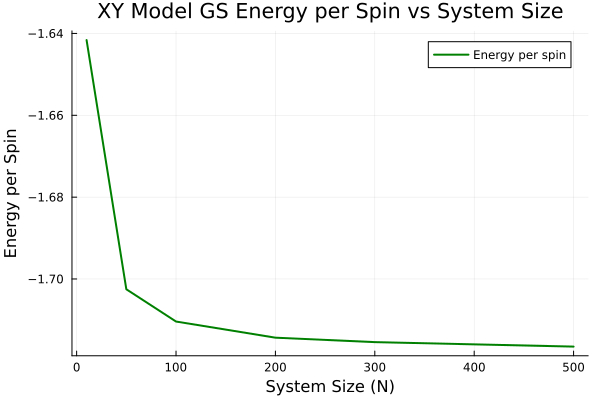

In [44]:
plt = plot(system_sizes, energy_per_spin, 
          color=:green, 
          linewidth=2, 
          label="Energy per spin",
          xlabel="System Size (N)", 
          ylabel="Energy per Spin", 
          title="XY Model GS Energy per Spin vs System Size")
# plot!(plt, [2, 500], [-0.318205, -0.318205],
#      line=:dash,
#      color=:black,
#      linewidth=1.5,
#      label="Exact Value = -0.318205")
savefig("Heis_Zeeman_model_energy.png")
plt